In [44]:
from data_preprocessing import extract_accelerometer_data, csv_to_dataset_list, csv_to_json, normate_dataset_period
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import zscore

In [2]:
ds = extract_accelerometer_data(r'C:\Users\Raoul\Documents\GitHub\Boxschlag-Klassifikation\data\Max_Kinnhacken.csv')

data_2 = pd.read_csv(r'C:\Users\Raoul\Documents\GitHub\Boxschlag-Klassifikation\data\Max_Kinnhacken.csv')
data_1 = pd.read_csv(r'C:\Users\Raoul\Documents\GitHub\Boxschlag-Klassifikation\data\Max_Gerade.csv')
data_3 = pd.read_csv(r'C:\Users\Raoul\Documents\GitHub\Boxschlag-Klassifikation\data\Max_Kopfhacken.csv')
data_4 = pd.read_csv(r'C:\Users\Raoul\Documents\GitHub\Boxschlag-Klassifikation\data\Max_Gemischt_01.csv')
data_5 = pd.read_csv(r'C:\Users\Raoul\Documents\GitHub\Boxschlag-Klassifikation\data\Max_Gemischt_02.csv')

In [42]:
#Funktionen

def plot_ds(ds):
    x, y, z = [], [], []
    ds_ = ds.to_dict('records')
    for ds_e in ds_:
        x.append(ds_e['x'])
        y.append(ds_e['y'])
        z.append(ds_e['z'])

    t = np.arange(0, len(x))
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(t, x, label='x-Achse')
    ax.plot(t, y, label='y-Achse')
    ax.plot(t, z, label='z-Achse')

    ax.set(xlabel='datastamps', ylabel='a (in m/s²)',
           title='single dataset element of type: Kinnhacken')
    ax.grid()
    plt.legend()
    plt.show()
    '''''
    x_values = ds['x'].values
    plt.plot(x_values[400:450])
    plt.xlabel('Index')
    plt.ylabel('X Value')
    plt.title('Plot of X Values')
    plt.show()
    '''''


def plot_ds_1(ds):
    x, y, z = [], [], []
    ds_ = ds.to_dict('records')
    for ds_e in ds_:
        x.append(ds_e['x'])
        y.append(ds_e['y'])
        z.append(ds_e['z'])

    t = np.arange(0, len(x))

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(t, x, 'r.', label='x-Achse')
    ax.plot(t, y, 'b*', label='y-Achse')
    ax.plot(t, z, 'g^', label='z-Achse')

    ax.set(xlabel='Abtastwerte', ylabel='a (in m/s²)',
           title='Rohdaten eines Upper-Cuts')
    ax.grid()
    plt.legend()
    plt.show()
def interpolate_dataset(ds_el,sampling_rateNS = 0, interpolationKind='cubic'):
    # Funktioniert erst, wenn gelabelt und in raw-Form gebracht wurde

    the_cols = ['timestamp', 'x', 'y', 'z', 'label']
    data = []
    idxs = []
    sample_moment = 0
    idx = 0


    # stores the interpolating functions for each dataset element and axis
    f_x = (interp1d(ds_el['timestamp'].values.copy(), ds_el['x'].values.copy(), kind=interpolationKind,
                    bounds_error=False, fill_value=(ds_el['x'][0].copy(), ds_el['x'][0].copy())))
    f_y = (interp1d(ds_el['timestamp'].values.copy(), ds_el['y'].values.copy(), kind=interpolationKind,
                    bounds_error=False, fill_value=(ds_el['y'][0].copy(), ds_el['y'][0].copy())))
    f_z = (interp1d(ds_el['timestamp'].values.copy(), ds_el['z'].values.copy(), kind=interpolationKind,
                    bounds_error=False, fill_value=(ds_el['z'][0].copy(), ds_el['z'][0].copy())))

    while sample_moment < ds['timestamp'].values[-1]:
        data.append([float(f_x(sample_moment).copy()), float(f_y(sample_moment).copy()), float(f_z(sample_moment).copy()), int(
                   # dataset_raws_storer.append([5.3, 5.3, 5.3, int(
                   sample_moment), ds_el['label'][0]])
        sample_moment += sampling_rateNS/2
        idxs.append(idx)
        idx += 1

    print(idx)
    ds_interp = pd.DataFrame(data, columns=the_cols, index=idxs)

    return ds_interp

def interpolate_dataset_1(ds_el,sampling_rateNS = 0, interpolationKind='cubic'):

    f_x = (interp1d(ds_el['timestamp'].values.copy(), ds_el['x'].values.copy(), kind=interpolationKind,
            bounds_error=False, fill_value=(ds_el['x'][0].copy(), ds_el['x'][0].copy())))
    f_y = interp1d(ds_el['timestamp'].values.copy(), ds_el['y'].values.copy(), kind=interpolationKind)
    f_z = interp1d(ds_el['timestamp'].values.copy(), ds_el['z'].values.copy(), kind=interpolationKind)

    return f_x

def auto_labeling(data, window_size, sigma):
    # Assuming df is your DataFrame and 'column_name' is the column of interest
    df = pd.DataFrame(data, columns=['x'])
    
    
    rolling = df['x'].rolling(window=175, min_periods=window_size-1, center= False)
    mean = rolling.mean()
    std = rolling.std(ddof=0).replace(0, 1)
    
    # Calculate Z-scores
    #df['Z_score'] = zscore(df['x'])
    
    # Find spikes
    #spikes = df[df['Z_score'].abs() > threshold]
    #spikes = spikes[['timestamp','x']]
    peak_points = (-df.abs() + mean + sigma * std).fillna(0).values.tolist()
    return (-df.abs() + mean + sigma * std).fillna(0)


In [ ]:
#Spielwiese1
#complete the function auto_labeling in the following way: the function should save the peak points of the x axis in a list.
print(ds)
ds_e = ds[400:1000]
ds_s = auto_labeling(ds_e, 5, 4)
#f_x = interpolate_dataset_1(ds_e)
#timestamps = np.linspace(ds_e['timestamp'].min(), ds_e['timestamp'].max(), len(ds_e))
#interpolated_values = f_x(timestamps)
plt.plot(ds_e['timestamp'], ds_e['x'], "blue", label="Original")
plt.scatter(ds_s['timestamp'], ds_s['x'], 8, "red", label="spikes")
#plt.plot(ds_e['timestamp'], interpolated_values, "red", label="Interpolated")
plt.legend()
plt.show()

          timestamp         x         y         z  label
0      0.000000e+00 -0.075134 -0.137909 -0.974808      0
1      9.968000e+06 -0.114166 -0.133636 -0.986053      0
2      1.993700e+07 -0.110001 -0.126785 -0.992798      0
3      2.990600e+07 -0.091461 -0.127213 -0.994644      0
4      3.987400e+07 -0.085663 -0.118439 -0.995636      0
...             ...       ...       ...       ...    ...
19877  1.981432e+11 -0.195786 -0.178268 -0.970993      0
19878  1.981531e+11 -0.178665 -0.194626 -0.990097      0
19879  1.981631e+11 -0.179794 -0.173599 -0.993530      0
19880  1.981731e+11 -0.126511 -0.064316 -0.988358      0
19881  1.981830e+11 -0.269653 -0.224777 -0.967087      0

[19882 rows x 5 columns]


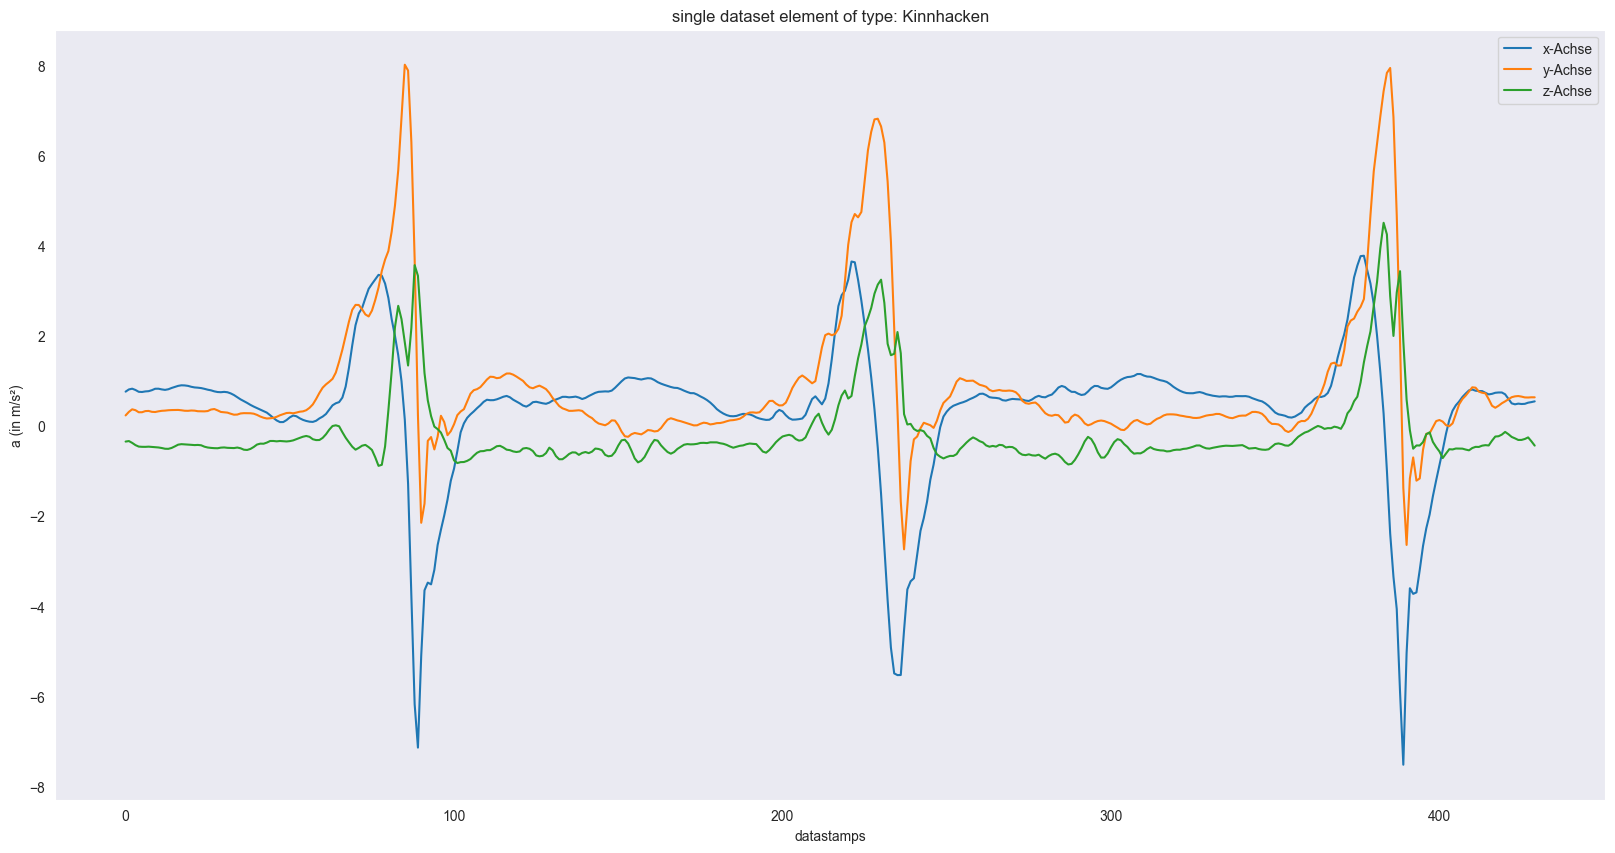

In [12]:
#Spielwiese2
print(ds)
plot_ds(ds[570:1000])

In [43]:
#Spielwiese3
df = auto_labeling(ds[570:1000],175, 0.5)
df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 570 to 999
Columns: 431 entries, 570 to x
dtypes: float64(431)
memory usage: 1.4 MB
     570  571  572  573  574  575  576  577  578  579  ...  991  992  993  \
570  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
571  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
572  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
573  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
574  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
999  0